In [1]:
#!pip install tensorflow-datasets pandas matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tensorflow.keras import models, layers, optimizers, Sequential, Model
from tensorflow.keras.layers import TextVectorization, Dense, Embedding, GlobalAveragePooling1D, Dropout, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers.experimental import RandomFourierFeatures


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import re, string


In [3]:
BATCH_SIZE = 128
VOCAB_SIZE = 100000
MAX_SEQUENCE = 200
EPOCHS = 50

In [4]:

(test, dev, train1, train2, train3), info = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', 
                                                      with_info=True, 
                                                      split=["train[0%:10%]", "train[10%:20%]", "train[20%:40%]", "train[20%:60%]", "train[20%:100%]"])

def text_cleanup(s):
    s = tf.strings.lower(s)
    # Remove html tags
    s = tf.strings.regex_replace(s,"<[^>]+>", " ")
    # Remove punctuation
    s = tf.strings.regex_replace(s, '[%s]' % re.escape(string.punctuation), ' ')
    s = tf.strings.regex_replace(s, '\s+', ' ')
    return s

def preprocess(ds, transform):
    ds = ds.map(transform, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def dataset_cleanup(_):
    return text_cleanup(_['data']['review_body']), (_['data']['star_rating']-1)/4

## Small dataset

In [5]:
train1.cardinality().numpy()

20995

## Medium dataset

In [6]:
train2.cardinality().numpy()

41990

## Large dataset

In [7]:
train3.cardinality().numpy()

83980

## Test dataset

In [8]:
test.cardinality().numpy()

10498

## Validation dataset

In [9]:
dev.cardinality().numpy()

10497

In [10]:
test = preprocess(test, dataset_cleanup)
dev = preprocess(dev, dataset_cleanup)
train1 = preprocess(train1, dataset_cleanup)
train2 = preprocess(train2, dataset_cleanup)
train3 = preprocess(train3, dataset_cleanup)

for x,y in test.take(1):
    for i in range(3):
      print("{} : {}".format(y[i], x[i]))

0.0 : b'does not work'
0.75 : b'this is a great wiring kit i used it to set up my pyle 2000 watt amp to 2 alpine subs and worked just fine im not sure about the power cord and its length because my battery is in the back but the ground cord is a bit short and thats its only flaw and that why i gave it 4 stars great kit'
1.0 : b'it works great so much faster than usb charger buy it you will be glad you did '


## Get GloVe embeddings to use instead of 1-hot.

In [11]:
EMBEDDING_DIM = 100
def getGlove():
    path_to_glove_file = "glove.6B.100d.txt"
    embeddings_index = {}
    word_index = []
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
            word_index.append(word)
    print("Found %s word vectors." % len(embeddings_index))
    num_tokens = len(embeddings_index)
    embedding_matrix = np.zeros((num_tokens+2, EMBEDDING_DIM))
    for i, word in enumerate(word_index):
        embedding_vector = embeddings_index.get(word)
        embedding_matrix[i+2] = embedding_vector
    return word_index, embedding_matrix

vocabulary, embedding = getGlove()

Found 400000 word vectors.


## Common layers

In [12]:
num_tokens = len(vocabulary)+2
vectorize_layer = TextVectorization(
 max_tokens=num_tokens,
 output_mode='int',
 output_sequence_length=MAX_SEQUENCE,
 vocabulary=vocabulary
)
embedding_layer = Embedding(
 num_tokens, 
 EMBEDDING_DIM,
 embeddings_initializer = keras.initializers.Constant(embedding),
 trainable=False)

In [13]:
vectorize_layer("does not work")

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([262,  38, 163,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  

In [14]:
embedding_layer(vectorize_layer("does not work"))

<tf.Tensor: shape=(200, 100), dtype=float32, numpy=
array([[-0.093402,  0.55602 ,  0.74852 , ..., -0.6857  ,  0.20876 ,
         0.59025 ],
       [-0.19104 ,  0.17601 ,  0.3692  , ..., -0.5968  ,  0.080843,
         0.27866 ],
       [-0.11619 ,  0.45447 , -0.69216 , ..., -0.54737 ,  0.48822 ,
         0.32246 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)>

## Define SVM approximation using RandomFourier. (not working)

In [15]:
def svm_model(hyperplanes):
    # https://keras.io/examples/keras_recipes/quasi_svm/
    string_input = keras.Input(shape=(1,), dtype="string")
    x = vectorize_layer(string_input)
    x = embedding_layer(x)
    x = Dropout(.1)
    x = RandomFourierFeatures(
            output_dim=hyperplanes, scale=10.0, kernel_initializer="gaussian"
        )(x)
    x = Dropout(.1)
    score = Dense(1)(x)
    model = Model(string_input, score)
    model._name = f"SVM_{hyperplanes})"
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1),
                  loss='mean_squared_error', metrics=['accuracy', 'mse'])
    return model

## Define an LSTM

In [16]:
def lstm_model(output_size=256):
    string_input = keras.Input(shape=(1,), dtype="string")
    x = vectorize_layer(string_input)
    x = embedding_layer(x)
    x = LSTM(output_size, dropout=.1, recurrent_dropout=.1)(x)
    score = Dense(1)(x)
    model = Model(string_input, score)
    model._name = f"LSTM_{output_size}"
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss='mean_squared_error', metrics=['mae', 'mse'])
    return model
    

## Define a CNN model

In [17]:
def cnn_model(convolutions=3, filters = 128, kernel_size = 5):
    string_input = keras.Input(shape=(1,), dtype="string")
    x = vectorize_layer(string_input)
    x = embedding_layer(x)
    x = Conv1D(filters, kernel_size, activation="relu")(x)
    for i in range(convolutions -1):
        x = MaxPooling1D(kernel_size)(x)
        x = Conv1D(filters, kernel_size, activation="relu")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(filters, activation="relu")(x)
    x = Dropout(0.5)(x)
    score = Dense(1)(x)
    model = Model(string_input, score)
    model._name = f"CNN_{convolutions}_{filters}_{kernel_size}"
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss='mean_squared_error', metrics=['mae', 'mse'])
    return model

## Train models

In [18]:
def fit_model(model, dataset):
    history = model.fit(dataset, epochs=EPOCHS, validation_data=dev)
    return history

In [19]:
## Define drawings

In [20]:
def plot_history(title, ylabel, legend1, data1, legend2, data2):
    plt.plot(data1)
    plt.plot(data2)
    plt.title(title)
    plt.gca().set_ylim(0)
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend([legend1, legend2], loc='upper left')
    plt.savefig(f"{title}-.pdf", format="pdf", bbox_inches="tight")
    plt.show()

## Small training set

In [21]:
cnn = cnn_model()
lstm = lstm_model()

cnn_history = fit_model(cnn, train1)
lstm_history = fit_model(lstm, train1)

Model: "CNN_3_128_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 100)          40000200  
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 39, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 128)           

Model: "LSTM_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 100)          40000200  
                                                                 
 lstm (LSTM)                 (None, 256)               365568    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 40,366,025
Trainable params: 365,825
Non-trainable params: 40,000,200
________________________________________

Epoch 43/50
165/165 [==============================] - 47s 286ms/step - loss: 0.1458 - mae: 0.3308 - mse: 0.1458 - val_loss: 0.1438 - val_mae: 0.3304 - val_mse: 0.1438
Epoch 44/50
165/165 [==============================] - 47s 285ms/step - loss: 0.1458 - mae: 0.3308 - mse: 0.1458 - val_loss: 0.1438 - val_mae: 0.3305 - val_mse: 0.1438
Epoch 45/50
165/165 [==============================] - 47s 287ms/step - loss: 0.1458 - mae: 0.3308 - mse: 0.1458 - val_loss: 0.1438 - val_mae: 0.3305 - val_mse: 0.1438
Epoch 46/50
165/165 [==============================] - 47s 284ms/step - loss: 0.1458 - mae: 0.3308 - mse: 0.1458 - val_loss: 0.1438 - val_mae: 0.3306 - val_mse: 0.1438
Epoch 47/50
165/165 [==============================] - 49s 296ms/step - loss: 0.1458 - mae: 0.3308 - mse: 0.1458 - val_loss: 0.1438 - val_mae: 0.3306 - val_mse: 0.1438
Epoch 48/50
165/165 [==============================] - 47s 288ms/step - loss: 0.1458 - mae: 0.3308 - mse: 0.1458 - val_loss: 0.1438 - val_mae: 0.3306 - val_mse:

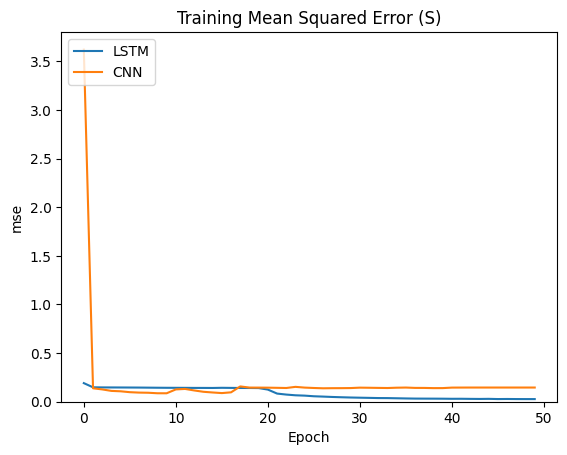

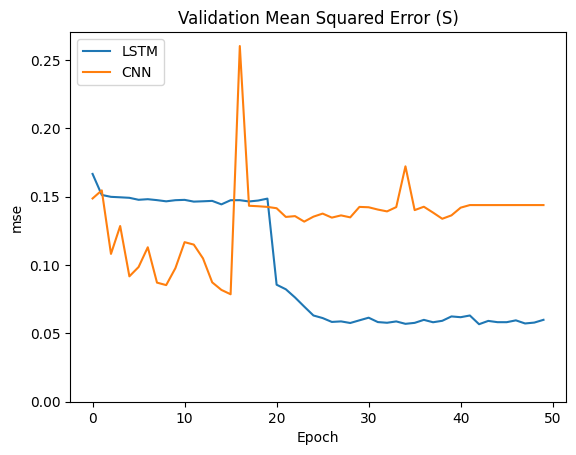

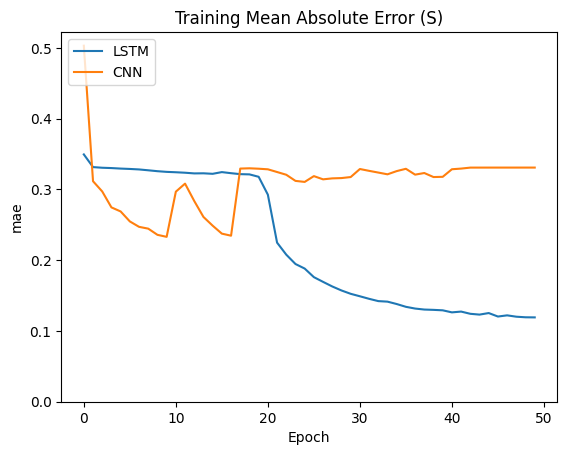

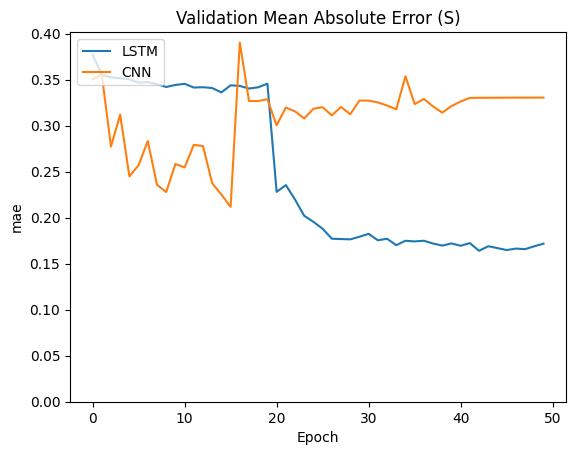

In [22]:
plot_history("Training Mean Squared Error (S)", "mse", "LSTM", lstm_history.history['mse'], "CNN", cnn_history.history['mse'])
plot_history("Validation Mean Squared Error (S)", "mse", "LSTM", lstm_history.history['val_mse'], "CNN", cnn_history.history['val_mse'])
plot_history("Training Mean Absolute Error (S)", "mae", "LSTM", lstm_history.history['mae'], "CNN", cnn_history.history['mae'])
plot_history("Validation Mean Absolute Error (S)", "mae", "LSTM", lstm_history.history['val_mae'], "CNN", cnn_history.history['val_mae'])

### Evaluate against test

In [23]:
eval_cnn_small = cnn.evaluate(test)
eval_lstm_small = lstm.evaluate(test)

83/83 [==============================] - 46s 553ms/step - loss: 0.0624 - mae: 0.1730 - mse: 0.0624


## Medium training set

In [24]:
cnn = cnn_model()
lstm = lstm_model()

cnn_history = fit_model(cnn, train2)
lstm_history = fit_model(lstm, train2)

Model: "CNN_3_128_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 100)          40000200  
                                                                 
 conv1d_3 (Conv1D)           (None, 196, 128)          64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 39, 128)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 35, 128)           

Model: "LSTM_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 100)          40000200  
                                                                 
 lstm_1 (LSTM)               (None, 256)               365568    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 40,366,025
Trainable params: 365,825
Non-trainable params: 40,000,200
________________________________________

Epoch 43/50
329/329 [==============================] - 237s 721ms/step - loss: 0.1245 - mae: 0.2915 - mse: 0.1245 - val_loss: 0.0916 - val_mae: 0.2403 - val_mse: 0.0916
Epoch 44/50
329/329 [==============================] - 215s 653ms/step - loss: 0.1319 - mae: 0.2971 - mse: 0.1319 - val_loss: 0.1434 - val_mae: 0.3209 - val_mse: 0.1434
Epoch 45/50
329/329 [==============================] - 180s 548ms/step - loss: 0.1449 - mae: 0.3277 - mse: 0.1449 - val_loss: 0.1418 - val_mae: 0.3177 - val_mse: 0.1418
Epoch 46/50
329/329 [==============================] - 187s 569ms/step - loss: 0.1426 - mae: 0.3212 - mse: 0.1426 - val_loss: 0.1324 - val_mae: 0.3060 - val_mse: 0.1324
Epoch 47/50
329/329 [==============================] - 203s 617ms/step - loss: 0.1492 - mae: 0.3262 - mse: 0.1492 - val_loss: 0.1438 - val_mae: 0.3210 - val_mse: 0.1438
Epoch 48/50
329/329 [==============================] - 195s 594ms/step - loss: 0.1454 - mae: 0.3286 - mse: 0.1454 - val_loss: 0.1438 - val_mae: 0.3208 - va

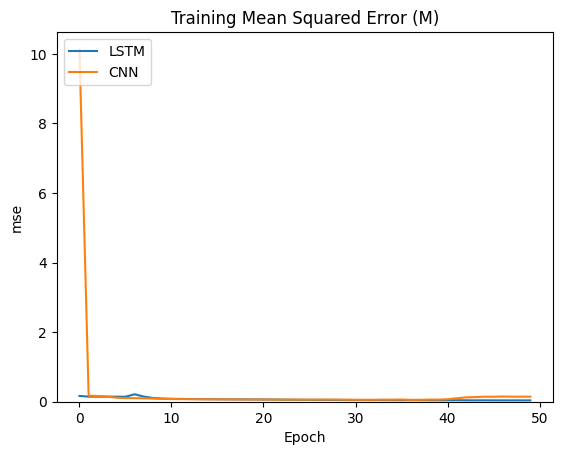

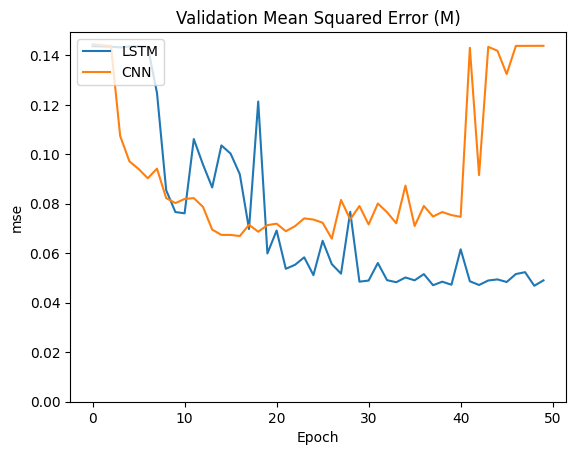

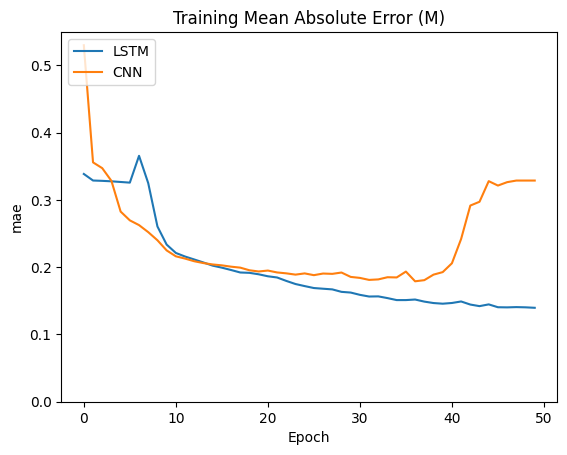

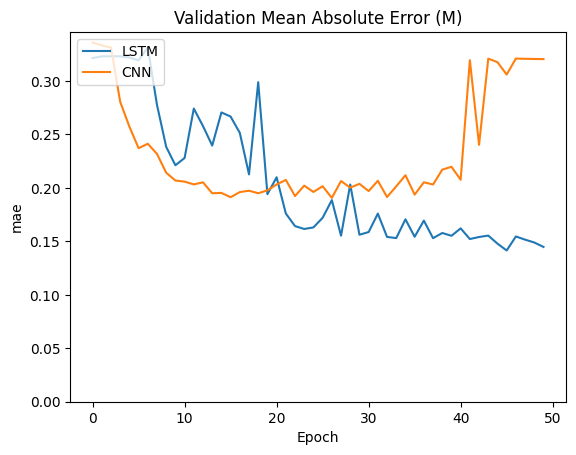

In [25]:
plot_history("Training Mean Squared Error (M)", "mse", "LSTM", lstm_history.history['mse'], "CNN", cnn_history.history['mse'])
plot_history("Validation Mean Squared Error (M)", "mse", "LSTM", lstm_history.history['val_mse'], "CNN", cnn_history.history['val_mse'])
plot_history("Training Mean Absolute Error (M)", "mae", "LSTM", lstm_history.history['mae'], "CNN", cnn_history.history['mae'])
plot_history("Validation Mean Absolute Error (M)", "mae", "LSTM", lstm_history.history['val_mae'], "CNN", cnn_history.history['val_mae'])

### Evaluate against test

In [26]:
eval_cnn_mid = cnn.evaluate(test)
eval_lstm_mid = lstm.evaluate(test)

83/83 [==============================] - 30s 361ms/step - loss: 0.0514 - mae: 0.1467 - mse: 0.0514


## Large training set

In [27]:
cnn = cnn_model()
lstm = lstm_model()

cnn_history = fit_model(cnn, train3)
lstm_history = fit_model(lstm, train3)

Model: "CNN_3_128_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 100)          40000200  
                                                                 
 conv1d_6 (Conv1D)           (None, 196, 128)          64128     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 39, 128)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 35, 128)           

Model: "LSTM_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 100)          40000200  
                                                                 
 lstm_2 (LSTM)               (None, 256)               365568    
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 40,366,025
Trainable params: 365,825
Non-trainable params: 40,000,200
________________________________________

Epoch 43/50
657/657 [==============================] - 182s 277ms/step - loss: 0.1280 - mae: 0.3007 - mse: 0.1280 - val_loss: 0.1121 - val_mae: 0.2722 - val_mse: 0.1121
Epoch 44/50
657/657 [==============================] - 181s 275ms/step - loss: 0.1168 - mae: 0.2839 - mse: 0.1168 - val_loss: 0.1062 - val_mae: 0.2651 - val_mse: 0.1062
Epoch 45/50
657/657 [==============================] - 182s 277ms/step - loss: 0.1110 - mae: 0.2759 - mse: 0.1110 - val_loss: 0.0993 - val_mae: 0.2449 - val_mse: 0.0993
Epoch 46/50
657/657 [==============================] - 179s 273ms/step - loss: 0.1129 - mae: 0.2780 - mse: 0.1129 - val_loss: 0.0988 - val_mae: 0.2517 - val_mse: 0.0988
Epoch 47/50
657/657 [==============================] - 183s 279ms/step - loss: 0.1063 - mae: 0.2687 - mse: 0.1063 - val_loss: 0.0918 - val_mae: 0.2463 - val_mse: 0.0918
Epoch 48/50
657/657 [==============================] - 181s 276ms/step - loss: 0.1027 - mae: 0.2638 - mse: 0.1027 - val_loss: 0.0898 - val_mae: 0.2437 - va

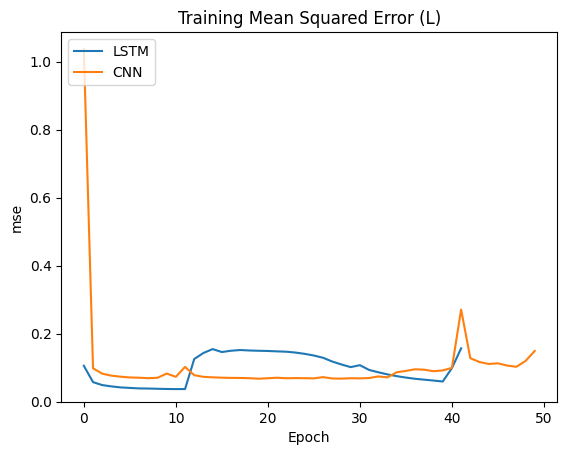

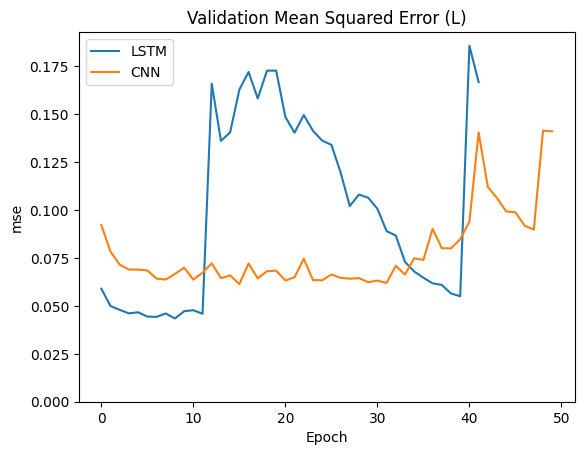

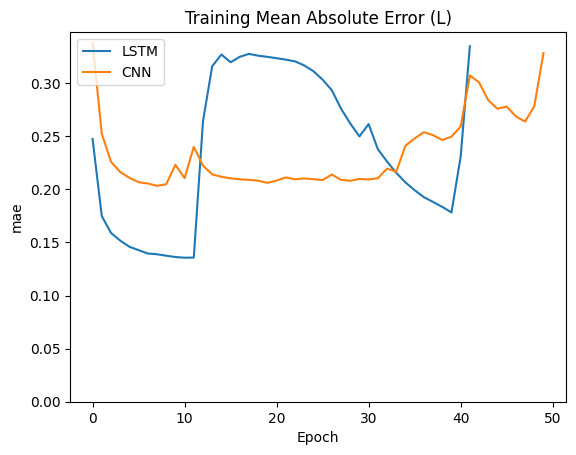

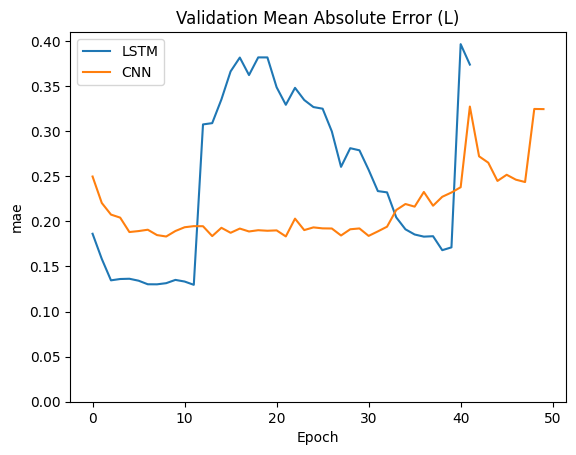

In [28]:
plot_history("Training Mean Squared Error (L)", "mse", "LSTM", lstm_history.history['mse'], "CNN", cnn_history.history['mse'])
plot_history("Validation Mean Squared Error (L)", "mse", "LSTM", lstm_history.history['val_mse'], "CNN", cnn_history.history['val_mse'])
plot_history("Training Mean Absolute Error (L)", "mae", "LSTM", lstm_history.history['mae'], "CNN", cnn_history.history['mae'])
plot_history("Validation Mean Absolute Error (L)", "mae", "LSTM", lstm_history.history['val_mae'], "CNN", cnn_history.history['val_mae'])

### Evaluate against test

In [29]:
eval_cnn_large = cnn.evaluate(test)
eval_lstm_large = lstm.evaluate(test)

83/83 [==============================] - 33s 392ms/step - loss: nan - mae: nan - mse: nan


## Plot test results

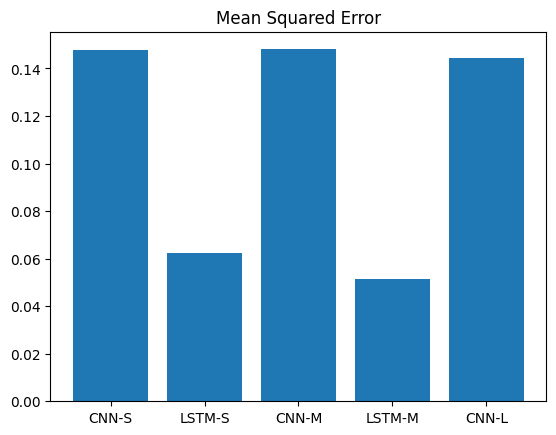

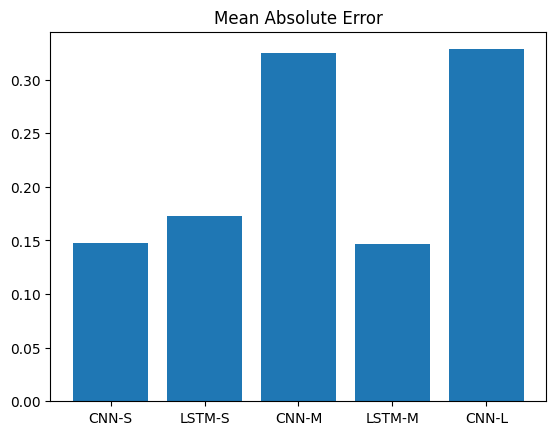

In [30]:
plt.bar(["CNN-S", "LSTM-S", "CNN-M", "LSTM-M", "CNN-L", "LSTM-L"], [eval_cnn_small[0], eval_lstm_small[0], eval_cnn_mid[0], eval_lstm_mid[0], eval_cnn_large[0], eval_lstm_large[0]])
plt.title("Mean Squared Error")
plt.savefig(f"mse-all.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.bar(["CNN-S", "LSTM-S", "CNN-M", "LSTM-M", "CNN-L", "LSTM-L"], [eval_cnn_small[0], eval_lstm_small[1], eval_cnn_mid[1], eval_lstm_mid[1], eval_cnn_large[1], eval_lstm_large[1]])
plt.title("Mean Absolute Error")
plt.savefig(f"mae-all.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Redo lstm with 40 epochs to avoid nan error

In [32]:
EPOCHS = 40
lstm = lstm_model()
lstm_history = fit_model(lstm, train3)
eval_lstm_large = lstm.evaluate(test)

Model: "LSTM_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 100)          40000200  
                                                                 
 lstm_4 (LSTM)               (None, 256)               365568    
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 40,366,025
Trainable params: 365,825
Non-trainable params: 40,000,200
________________________________________

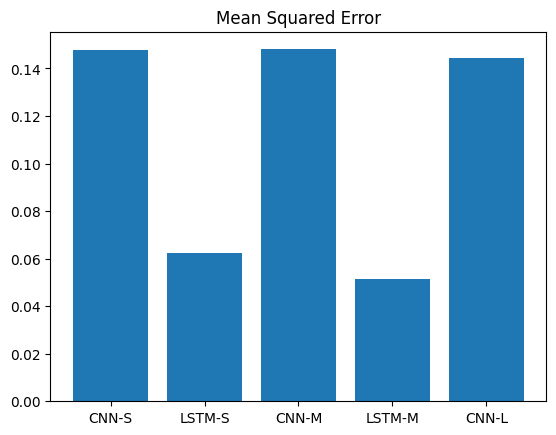

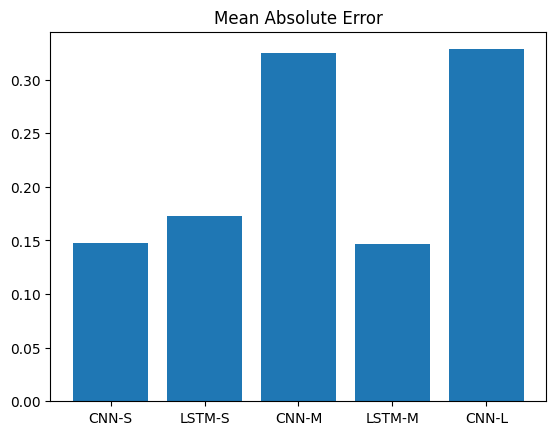

In [33]:
plt.bar(["CNN-S", "LSTM-S", "CNN-M", "LSTM-M", "CNN-L", "LSTM-L"], [eval_cnn_small[0], eval_lstm_small[0], eval_cnn_mid[0], eval_lstm_mid[0], eval_cnn_large[0], eval_lstm_large[0]])
plt.title("Mean Squared Error")
plt.savefig(f"mse-all.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.bar(["CNN-S", "LSTM-S", "CNN-M", "LSTM-M", "CNN-L", "LSTM-L"], [eval_cnn_small[0], eval_lstm_small[1], eval_cnn_mid[1], eval_lstm_mid[1], eval_cnn_large[1], eval_lstm_large[1]])
plt.title("Mean Absolute Error")
plt.savefig(f"mae-all.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [34]:
EPOCHS = 20
lstm = lstm_model()
lstm_history = fit_model(lstm, train3)
eval_lstm_large = lstm.evaluate(test)

Model: "LSTM_256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 100)          40000200  
                                                                 
 lstm_5 (LSTM)               (None, 256)               365568    
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 40,366,025
Trainable params: 365,825
Non-trainable params: 40,000,200
________________________________________

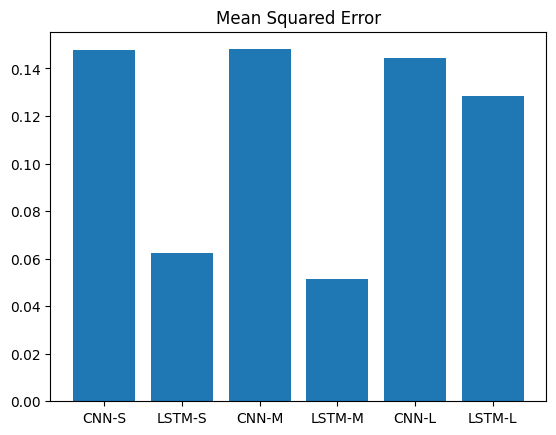

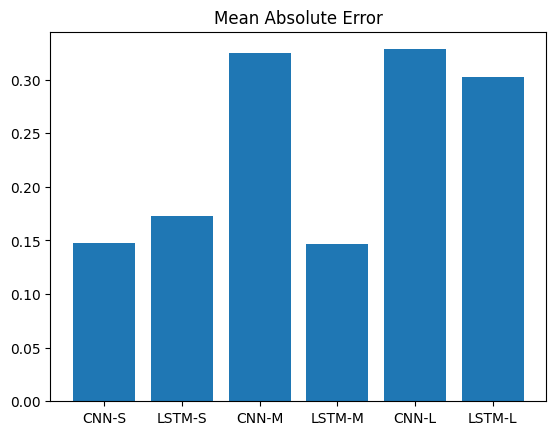

In [35]:
plt.bar(["CNN-S", "LSTM-S", "CNN-M", "LSTM-M", "CNN-L", "LSTM-L"], [eval_cnn_small[0], eval_lstm_small[0], eval_cnn_mid[0], eval_lstm_mid[0], eval_cnn_large[0], eval_lstm_large[0]])
plt.title("Mean Squared Error")
plt.savefig(f"mse-all.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.bar(["CNN-S", "LSTM-S", "CNN-M", "LSTM-M", "CNN-L", "LSTM-L"], [eval_cnn_small[0], eval_lstm_small[1], eval_cnn_mid[1], eval_lstm_mid[1], eval_cnn_large[1], eval_lstm_large[1]])
plt.title("Mean Absolute Error")
plt.savefig(f"mae-all.pdf", format="pdf", bbox_inches="tight")
plt.show()